In [1]:
import os
import sys

import numpy as np
import scipy.io

import sys
sys.path.append("../../dpc/")
from util.point_cloud import point_cloud_distance
from util.simple_dataset import Dataset3D
from util.app_config import config as app_config
from util.tools import partition_range, to_np_object
from util.quaternion import quaternion_rotate
from util.euler import ypr_from_campos

import torch
from torch.utils.tensorboard import SummaryWriter
from models import model_pc_to as model_pc
from util.system import setup_environment
from run.ShapeRecords import ShapeRecords

import pickle
import pdb

config.yaml
align_to_canonical = False
batch_size = 8
bicubic_gt_downsampling = False
camera_distance = 2.0
checkpoint_dir = .
clip_gradient_norm = 0.0
compute_validation_loss = True
config = 
decoder_conv_init_stdev = 0.02
decoder_name = pc_decoder
drc_logsum = True
drc_logsum_clip_val = 1e-05
drc_rgb_weight = 0.0
drc_tf_cumulative = True
drc_weight = 0.0
encoder_name = img_encoder
eval_split = val
eval_unsupervised_shape = True
f_dim = 16
fc_dim = 1024
focal_length = 1.875
focal_length_mean = 2.0
focal_length_range = 1.0
focal_range = 0.7
gpu = 0
gpu_allow_growth = False
gt_pc_dir = ../../data/gt/downsampled
image_size = 128
inp_dir = ../../data/tf_records
input_shape = [128, 128, 3]
learn_focal_length = False
learning_rate = 0.0001
learning_rate_2 = 1e-05
learning_rate_step = 1.0
max_dataset_depth = 10.0
max_depth = 10.0
max_number_of_steps = 600000
models_list = 
num_dataset_samples = -1
num_views = 5
num_views_to_use = -1
pc_decoder_init_stddev = 0.025
pc_eval_chamfer_num_parts = 

../../dpc/util/config.py:46: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  yaml_cfg = edict(yaml.load(f))


In [2]:
def compute_distance(cfg, source_np, target_np):
    """
    compute projection from source to target
    """
    num_parts = cfg.pc_eval_chamfer_num_parts
    partition = partition_range(source_np.shape[0], num_parts)
    min_dist_np = np.zeros((0,))
    idx_np = np.zeros((0,))
    source_pc = torch.from_numpy(source_np).cuda()
    target_pc = torch.from_numpy(target_np).cuda()
    for k in range(num_parts):
        r = partition[k, :]
        src = source_pc[r[0]:r[1]]
        _, min_dist, min_idx = point_cloud_distance(src, target_pc)
        min_dist_0_np = min_dist.cpu().numpy()
        idx_0_np = min_idx.cpu().numpy()
        min_dist_np = np.concatenate((min_dist_np, min_dist_0_np), axis=0)
        idx_np = np.concatenate((idx_np, idx_0_np), axis=0)

    return min_dist_np, idx_np

In [3]:
def get_group(pos,divs):
    scale = divs/2
    yaw, pitch, roll = ypr_from_campos(pos[0], pos[1], pos[2])
    yaw = yaw + np.pi
    # get everything from 0 to 2*pi
    yaw = yaw%(2*np.pi)+0.00000001
    pitch = pitch%(2*np.pi)+0.00000001
    roll = roll%(2*np.pi) + 0.00000001
    
    q1 = np.ceil(scale*yaw/np.pi)-1
    q2 = np.ceil(scale*pitch/np.pi)-1
    q3 = np.ceil(scale*roll/np.pi)-1
    
    return q1*np.square(divs)+q2*divs+q3

def get_yaw_pitch_roll_range(g, divs):
    roll_range = [(g%divs)*2*np.pi/divs , (g%divs+1)*2*np.pi/divs]
    pitch_range = [(int(g/divs)%divs)*2*np.pi/divs, (int(g/divs)%divs+1)*2*np.pi/divs]
    yaw_range = [(int(g/np.square(divs))%divs)*2*np.pi/divs, (int(g/np.square(divs))%divs+1)*2*np.pi/divs]
    
    return yaw_range, pitch_range, roll_range

    

In [4]:
int(220/10)%10

2

In [5]:
    cfg = app_config

    setup_environment(cfg)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    train_dir = cfg.checkpoint_dir

    split_name = "eval"
    dataset_folder = cfg.inp_dir
    
    dataset = ShapeRecords(dataset_folder, cfg, 'test')
    dataset_loader = torch.utils.data.DataLoader(dataset,
                                                 batch_size=cfg.batch_size, shuffle=cfg.shuffle_dataset,
                                                 num_workers=4, drop_last=True)
    
    

Initialized dataset test with size 1355


In [6]:
    divs = 8
    cfg = app_config
    exp_dir = cfg.checkpoint_dir
    num_views = cfg.num_views
    eval_unsup = cfg.eval_unsupervised_shape
    dataset_folder = cfg.inp_dir

    gt_dir = os.path.join(cfg.gt_pc_dir, cfg.synth_set)

    save_pred_name = "{}_{}".format(cfg.save_predictions_dir, cfg.eval_split)
    save_dir = os.path.join(exp_dir, cfg.save_predictions_dir)

    if eval_unsup:
        reference_rotation = scipy.io.loadmat("{}/final_reference_rotation.mat".format(exp_dir))["rotation"]

    dataset = ShapeRecords(dataset_folder, cfg, 'test')

    if cfg.models_list:
        model_names = parse_lines(cfg.models_list)
    else:
        model_names = dataset.file_names
    num_models = len(model_names)

    # making groups for samples and views according to 8 groups of yaw, pitch, roll
    all_images = np.zeros((0,128,128,3))
    chamfer_all = np.zeros((0,2))
    groups = []

    for k in range(250):
        sample = dataset.__getitem__(k)

        print("{}/{}".format(k, num_models))
        print(model_names[k])

        gt_filename = "{}/{}.mat".format(gt_dir, model_names[k]).replace('_features.p', '')
        mat_filename = "{}/{}_pc.pkl".format(save_dir, model_names[k])

        if not os.path.isfile(gt_filename) or not os.path.isfile(mat_filename):
            continue

        with open(mat_filename, 'rb') as handle:
            data = pickle.load(handle)
        all_pcs = np.squeeze(data["points"])
        if "num_points" in data:
            all_pcs_nums = np.squeeze(data["num_points"])
            has_number = True
        else:
            has_number = False
        obj = scipy.io.loadmat(gt_filename)
        Vgt = obj["points"]

        for i in range(num_views):
            chamfer_dists_current = np.zeros((2), dtype=np.float64)

            pred = all_pcs[i, :, :]
            if has_number:
                pred = pred[0:all_pcs_nums[i], :]

            if eval_unsup:
                pred = np.expand_dims(pred, 0)
                pred = quaternion_rotate(torch.from_numpy(pred).cuda(),
                                         torch.from_numpy(reference_rotation).cuda()).cpu().numpy()
                pred = np.squeeze(pred)

            pred_to_gt, idx_np = compute_distance(cfg, pred, Vgt)
            gt_to_pred, _ = compute_distance(cfg, Vgt, pred)
            chamfer_dists_current[0] = np.mean(pred_to_gt)
            chamfer_dists_current[1] = np.mean(gt_to_pred)

            is_nan = np.isnan(pred_to_gt)
            assert (not np.any(is_nan))

            campos = sample['cam_pos'][i]
            images = sample['image'][i].transpose(1,2,0)
            g = get_group(campos, divs)
            groups.append(g)

            all_images = np.concatenate((all_images, np.expand_dims(images,0)))
            chamfer_all = np.concatenate((chamfer_all, np.expand_dims(chamfer_dists_current, 0)))
            #print(i, ":", chamfer_dists_current)
    groups = np.array(groups)
        # current_mean = np.mean(chamfer_dists_current, 0)
        # print("total:", current_mean)        

Initialized dataset test with size 1355
0/1355
eaf5428e15655d0b3c8d0fdfb1cc2535_features.p
1/1355
b360f2264526521f1dee989d1177ef4e_features.p
2/1355
330d08738230faf0bc78bb6f3ca89e4c_features.p
3/1355
70f1f85d47c970bb78dd615a59de5f05_features.p
4/1355
8b886cf32f340c89a9e00c019d029152_features.p
5/1355
be8dbd9726372752412dfc90452742c7_features.p
6/1355
77f5b356fa515f1f396bfe08dd5ca134_features.p
7/1355
9dc1371b6989479c9c0ca344f487323e_features.p
8/1355
736e9ee917f741193b908295ece2b069_features.p
9/1355
519d19f3adebd20aba49014d9a3afe99_features.p
10/1355
1d8d16c0750f22f5ece93f2bb0b6d036_features.p
11/1355
dfd92aab082e4915e3d9492680c47206_features.p
12/1355
40ee8ed17f6ea51224669056e0d19a1_features.p
13/1355
6b91f4fb8cdcd6f46fe24f5659031935_features.p
14/1355
7bb5321d1e63d8bb36b0f2a1430e993a_features.p
15/1355
99a16c86225e538d9e72cd13d3c26c66_features.p
16/1355
e2809feb8c0b535686c701087a194026_features.p
17/1355
e3d23dc47ddd9620c9be65dfbd21428b_features.p
18/1355
1d37a7fbe0810f963e83b2d32ed

157/1355
a14880ecec87a82bf9b9977a2406713a_features.p
158/1355
7715c9c229d80afaf487e71bd57b6e0c_features.p
159/1355
7035d480f6bda22938b39a90ee80e328_features.p
160/1355
7250e86b4feb699aa08cd647a48e605d_features.p
161/1355
280553e975d6b79fd2b12aa6a0f050b3_features.p
162/1355
948f1555282e27da190c615a2115d2f7_features.p
163/1355
a0421aff56cad16790a9ce3e4b15521e_features.p
164/1355
55740c07554a726257f40ff86fe708ff_features.p
165/1355
2d75f86921cb919b88dcbe86402c7c15_features.p
166/1355
9d151e778dd4a3f7f91663a74ccd2338_features.p
167/1355
33ab50198c84645ef91663a74ccd2338_features.p
168/1355
b41aaea5754adae0444b41d6d7f557fa_features.p
169/1355
270b86f1c341d7fc98d5fc0473d00a1c_features.p
170/1355
7b2d8c9f611071c7d810b14a81e12eca_features.p
171/1355
25196058a95b4fc3359e362142e70c8d_features.p
172/1355
54b6c08ddcd0762adbbc9440457e303e_features.p
173/1355
9dcede4115b4379e2af4036e9c51cbc4_features.p
174/1355
810cac0d137efb1d21bdbc0445d9f748_features.p
175/1355
cfe139c0e8b8cfdae342bce0d924820_featu

### Obtain means of every cluster while grouping by Cam Pose

### Visualizing Groups

In [16]:
import matplotlib.pyplot as plt
import random
def display_nn_images(images, n, displ_str=None):
    samples = random.sample(range(0,images.shape[0]), min(n*n,images.shape[0]))
    f, axarr = plt.subplots(n,n)
    sample_idx = 0
    for i in range(n):
        for j in range(n):
            if sample_idx==len(samples):
                break
            axarr[i,j].imshow(images[samples[sample_idx]])
            sample_idx+=1
    if displ_str is not None:
        plt.savefig('imgs/'+displ_str+'.png', dpi=300)
    plt.show()
    if displ_str is not None:
        print(displ_str)

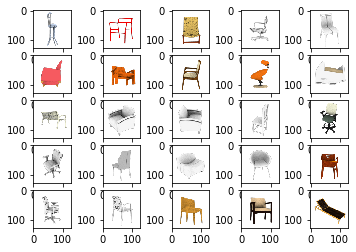

In [17]:
display_nn_images(all_images,5)

### PCA of all images

In [9]:
from sklearn.decomposition import PCA

In [10]:
images_val = all_images.reshape(all_images.shape[0],-1)
pca = PCA(50)
pca_image = pca.fit_transform(images_val)
pca_image = pca_image.reshape(-1,50)
print('Explained variance {}'.format(pca.explained_variance_ratio_.sum()))
all_images_pca = pca_image

Explained variance 0.7287256929490663


In [11]:
from sklearn.cluster import KMeans
n_clusters = 5

In [12]:
kmeans_all = KMeans(n_clusters=n_clusters,init='k-means++',random_state=0).fit(all_images_pca)

(76, 128, 128, 3)


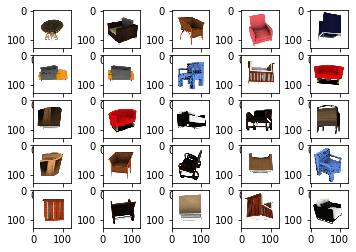

Chamfer Cluster 0: [4.36060366 5.65186207]


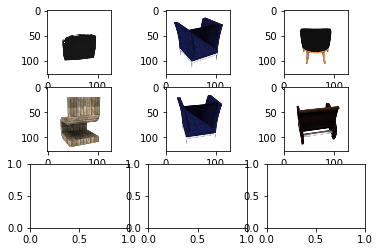

 Chamfer Cluster 0, Group 0.0: [5.64953139 5.85691286], Yaw: [0.0, 0.7853981633974483], Pitch: [0.0, 0.7853981633974483]


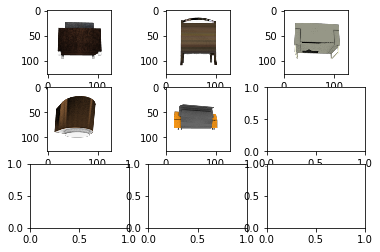

 Chamfer Cluster 0, Group 56.0: [3.46672462 5.69083502], Yaw: [0.0, 0.7853981633974483], Pitch: [5.497787143782138, 6.283185307179586]


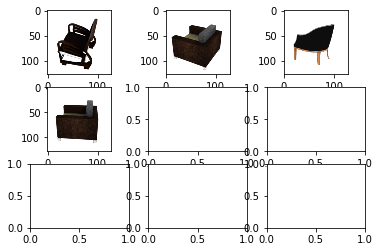

 Chamfer Cluster 0, Group 64.0: [3.55433113 4.7747852 ], Yaw: [0.7853981633974483, 1.5707963267948966], Pitch: [0.0, 0.7853981633974483]


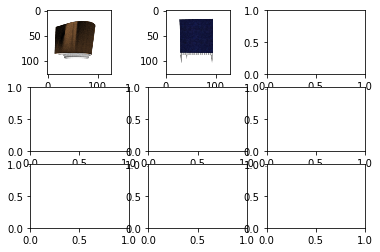

 Chamfer Cluster 0, Group 120.0: [4.09009077 5.43084736], Yaw: [0.7853981633974483, 1.5707963267948966], Pitch: [5.497787143782138, 6.283185307179586]


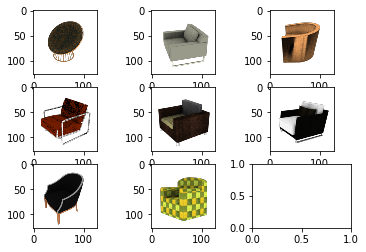

 Chamfer Cluster 0, Group 128.0: [3.72538779 6.04945396], Yaw: [1.5707963267948966, 2.356194490192345], Pitch: [0.0, 0.7853981633974483]


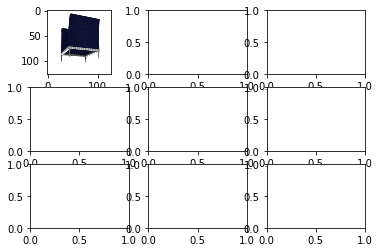

 Chamfer Cluster 0, Group 184.0: [4.79142675 4.32807481], Yaw: [1.5707963267948966, 2.356194490192345], Pitch: [5.497787143782138, 6.283185307179586]


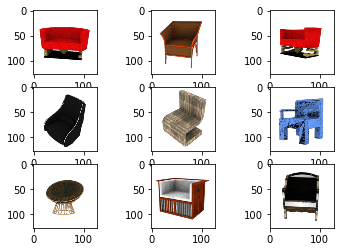

 Chamfer Cluster 0, Group 192.0: [5.06497182 5.24338132], Yaw: [2.356194490192345, 3.141592653589793], Pitch: [0.0, 0.7853981633974483]


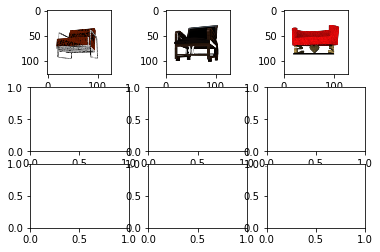

 Chamfer Cluster 0, Group 248.0: [4.17562302 4.35064534], Yaw: [2.356194490192345, 3.141592653589793], Pitch: [5.497787143782138, 6.283185307179586]


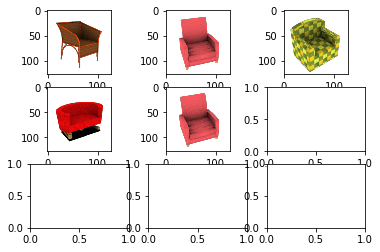

 Chamfer Cluster 0, Group 256.0: [5.56650881 6.22884001], Yaw: [3.141592653589793, 3.9269908169872414], Pitch: [0.0, 0.7853981633974483]


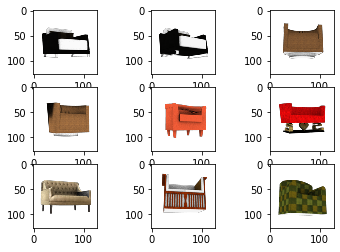

 Chamfer Cluster 0, Group 312.0: [3.52204332 6.47314848], Yaw: [3.141592653589793, 3.9269908169872414], Pitch: [5.497787143782138, 6.283185307179586]


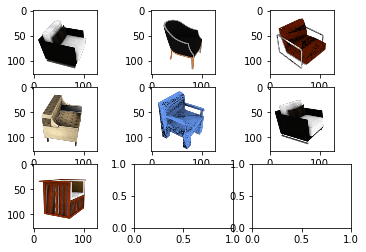

 Chamfer Cluster 0, Group 320.0: [3.49696912 5.54559521], Yaw: [3.9269908169872414, 4.71238898038469], Pitch: [0.0, 0.7853981633974483]


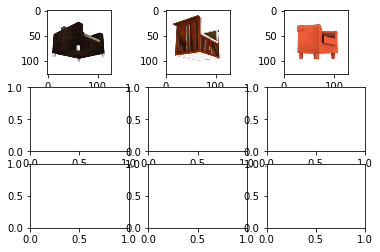

 Chamfer Cluster 0, Group 376.0: [3.51919336 6.10195882], Yaw: [3.9269908169872414, 4.71238898038469], Pitch: [5.497787143782138, 6.283185307179586]


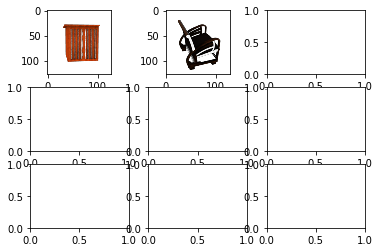

 Chamfer Cluster 0, Group 384.0: [4.7817092  5.09982537], Yaw: [4.71238898038469, 5.497787143782138], Pitch: [0.0, 0.7853981633974483]


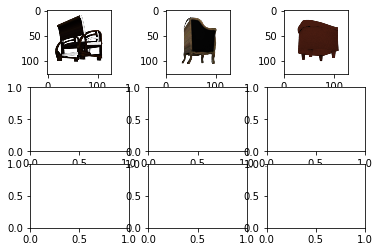

 Chamfer Cluster 0, Group 440.0: [3.55310231 3.501256  ], Yaw: [4.71238898038469, 5.497787143782138], Pitch: [5.497787143782138, 6.283185307179586]


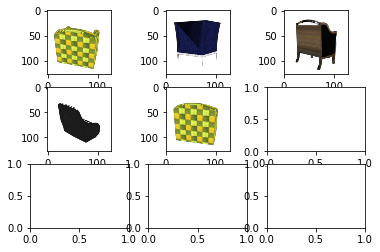

 Chamfer Cluster 0, Group 448.0: [6.06805295 7.28741365], Yaw: [5.497787143782138, 6.283185307179586], Pitch: [0.0, 0.7853981633974483]


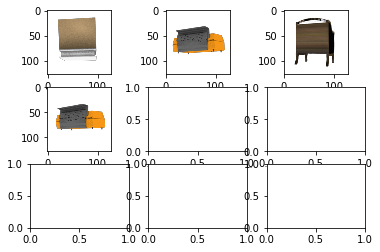

 Chamfer Cluster 0, Group 504.0: [4.985282   4.83772224], Yaw: [5.497787143782138, 6.283185307179586], Pitch: [5.497787143782138, 6.283185307179586]
(206, 128, 128, 3)


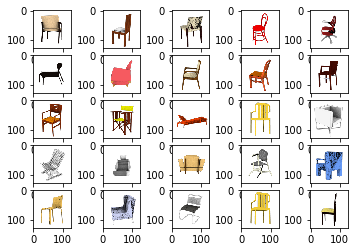

Chamfer Cluster 1: [3.3545937  3.38282366]


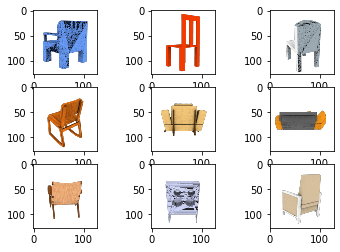

 Chamfer Cluster 1, Group 0.0: [3.18215778 3.177329  ], Yaw: [0.0, 0.7853981633974483], Pitch: [0.0, 0.7853981633974483]


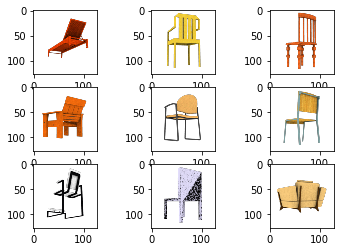

 Chamfer Cluster 1, Group 56.0: [3.65901478 3.54076239], Yaw: [0.0, 0.7853981633974483], Pitch: [5.497787143782138, 6.283185307179586]


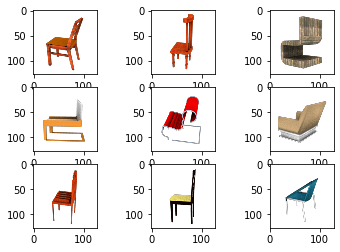

 Chamfer Cluster 1, Group 64.0: [2.96892249 2.91776523], Yaw: [0.7853981633974483, 1.5707963267948966], Pitch: [0.0, 0.7853981633974483]


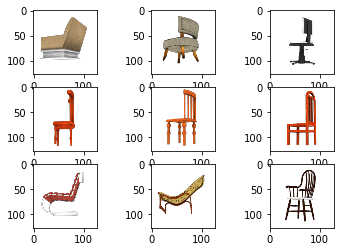

 Chamfer Cluster 1, Group 120.0: [3.08733477 3.09324368], Yaw: [0.7853981633974483, 1.5707963267948966], Pitch: [5.497787143782138, 6.283185307179586]


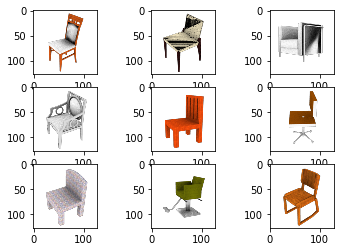

 Chamfer Cluster 1, Group 128.0: [3.07941124 3.12866395], Yaw: [1.5707963267948966, 2.356194490192345], Pitch: [0.0, 0.7853981633974483]


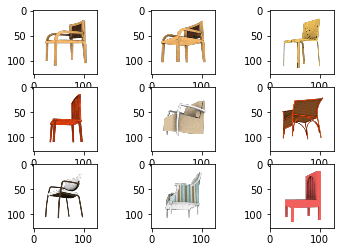

 Chamfer Cluster 1, Group 184.0: [3.30218497 3.03686331], Yaw: [1.5707963267948966, 2.356194490192345], Pitch: [5.497787143782138, 6.283185307179586]


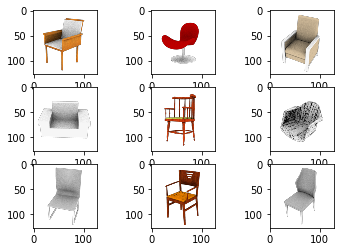

 Chamfer Cluster 1, Group 192.0: [4.41792677 4.27754864], Yaw: [2.356194490192345, 3.141592653589793], Pitch: [0.0, 0.7853981633974483]


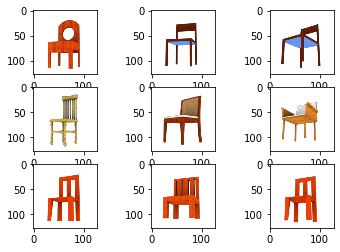

 Chamfer Cluster 1, Group 248.0: [3.08822204 2.89306897], Yaw: [2.356194490192345, 3.141592653589793], Pitch: [5.497787143782138, 6.283185307179586]


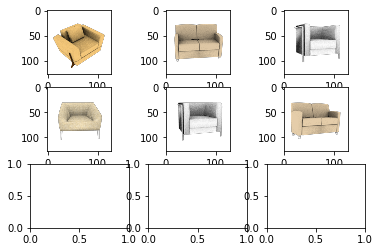

 Chamfer Cluster 1, Group 256.0: [3.77223368 6.72175747], Yaw: [3.141592653589793, 3.9269908169872414], Pitch: [0.0, 0.7853981633974483]


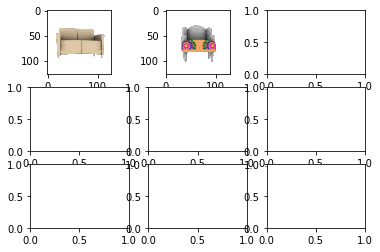

 Chamfer Cluster 1, Group 312.0: [3.56076347 5.58675374], Yaw: [3.141592653589793, 3.9269908169872414], Pitch: [5.497787143782138, 6.283185307179586]


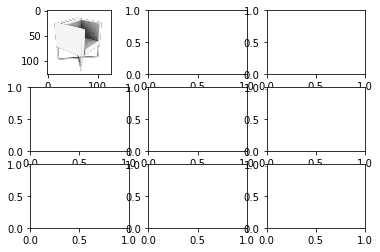

 Chamfer Cluster 1, Group 320.0: [3.54221073 2.96809903], Yaw: [3.9269908169872414, 4.71238898038469], Pitch: [0.0, 0.7853981633974483]


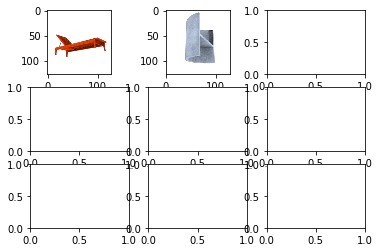

 Chamfer Cluster 1, Group 376.0: [9.93571872 7.69448362], Yaw: [3.9269908169872414, 4.71238898038469], Pitch: [5.497787143782138, 6.283185307179586]


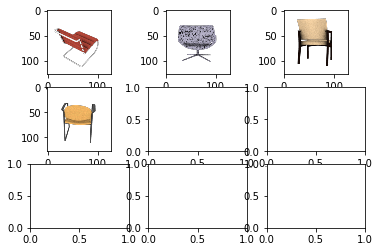

 Chamfer Cluster 1, Group 448.0: [2.75975688 2.47422181], Yaw: [5.497787143782138, 6.283185307179586], Pitch: [0.0, 0.7853981633974483]


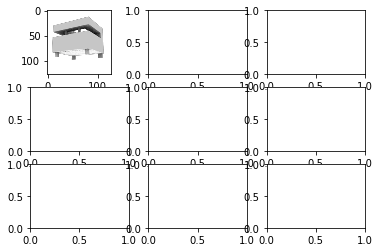

 Chamfer Cluster 1, Group 504.0: [3.70848252 7.83633363], Yaw: [5.497787143782138, 6.283185307179586], Pitch: [5.497787143782138, 6.283185307179586]
(142, 128, 128, 3)


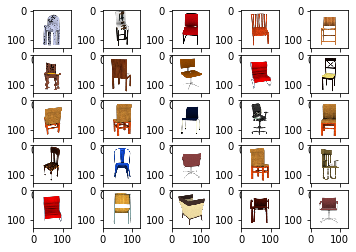

Chamfer Cluster 2: [2.80302545 2.65681388]


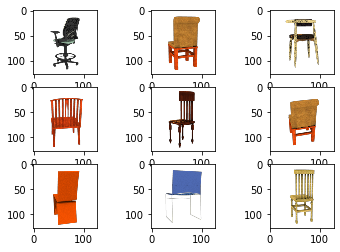

 Chamfer Cluster 2, Group 0.0: [2.88739815 2.72445041], Yaw: [0.0, 0.7853981633974483], Pitch: [0.0, 0.7853981633974483]


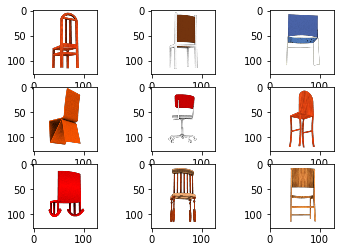

 Chamfer Cluster 2, Group 56.0: [3.44490868 2.95016206], Yaw: [0.0, 0.7853981633974483], Pitch: [5.497787143782138, 6.283185307179586]


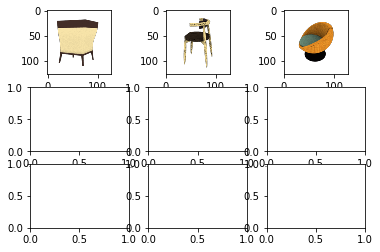

 Chamfer Cluster 2, Group 64.0: [2.37144143 2.32964292], Yaw: [0.7853981633974483, 1.5707963267948966], Pitch: [0.0, 0.7853981633974483]


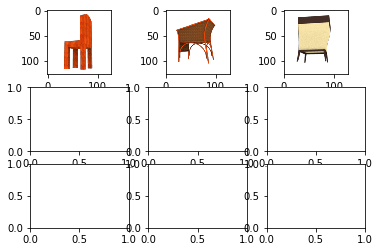

 Chamfer Cluster 2, Group 120.0: [3.35870443 2.55176773], Yaw: [0.7853981633974483, 1.5707963267948966], Pitch: [5.497787143782138, 6.283185307179586]


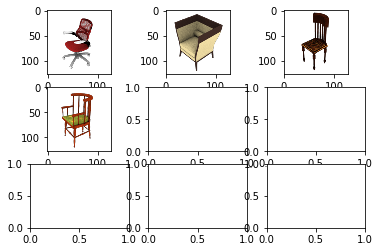

 Chamfer Cluster 2, Group 128.0: [2.22516031 2.19412602], Yaw: [1.5707963267948966, 2.356194490192345], Pitch: [0.0, 0.7853981633974483]


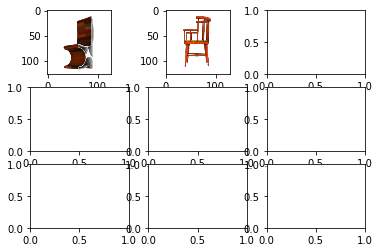

 Chamfer Cluster 2, Group 184.0: [6.39249918 5.94358845], Yaw: [1.5707963267948966, 2.356194490192345], Pitch: [5.497787143782138, 6.283185307179586]


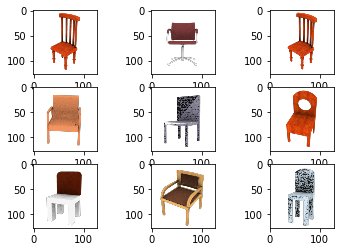

 Chamfer Cluster 2, Group 192.0: [2.58718804 2.50080343], Yaw: [2.356194490192345, 3.141592653589793], Pitch: [0.0, 0.7853981633974483]


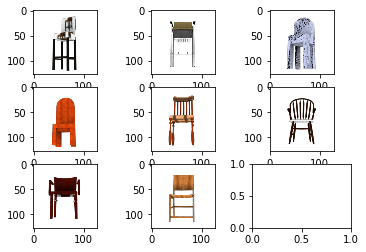

 Chamfer Cluster 2, Group 248.0: [2.48294798 2.60735457], Yaw: [2.356194490192345, 3.141592653589793], Pitch: [5.497787143782138, 6.283185307179586]


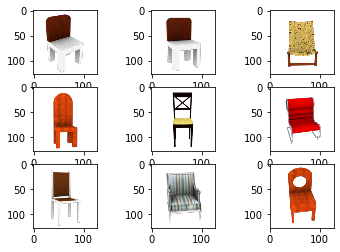

 Chamfer Cluster 2, Group 256.0: [2.76294707 2.53776833], Yaw: [3.141592653589793, 3.9269908169872414], Pitch: [0.0, 0.7853981633974483]


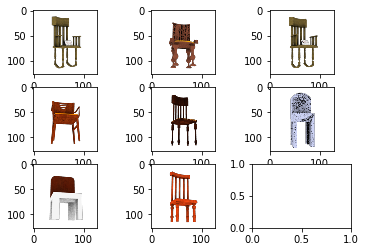

 Chamfer Cluster 2, Group 312.0: [1.92741856 2.27942098], Yaw: [3.141592653589793, 3.9269908169872414], Pitch: [5.497787143782138, 6.283185307179586]


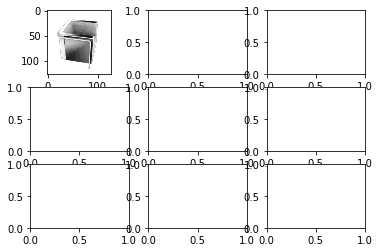

 Chamfer Cluster 2, Group 320.0: [2.94375826 5.90617831], Yaw: [3.9269908169872414, 4.71238898038469], Pitch: [0.0, 0.7853981633974483]


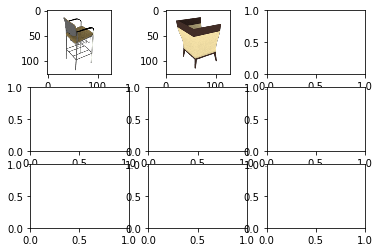

 Chamfer Cluster 2, Group 384.0: [2.70517792 2.34598434], Yaw: [4.71238898038469, 5.497787143782138], Pitch: [0.0, 0.7853981633974483]


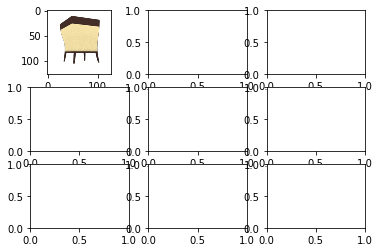

 Chamfer Cluster 2, Group 440.0: [4.36802996 2.16190131], Yaw: [4.71238898038469, 5.497787143782138], Pitch: [5.497787143782138, 6.283185307179586]


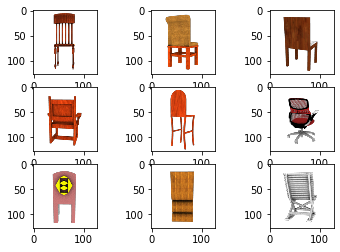

 Chamfer Cluster 2, Group 448.0: [2.5471222  2.76829896], Yaw: [5.497787143782138, 6.283185307179586], Pitch: [0.0, 0.7853981633974483]


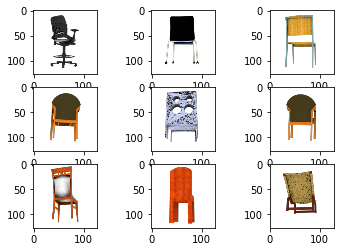

 Chamfer Cluster 2, Group 504.0: [2.81707354 2.32176019], Yaw: [5.497787143782138, 6.283185307179586], Pitch: [5.497787143782138, 6.283185307179586]
(201, 128, 128, 3)


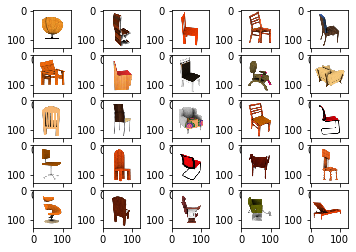

Chamfer Cluster 3: [3.61476767 3.46801977]


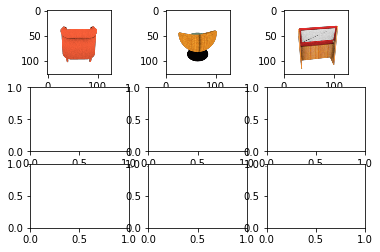

 Chamfer Cluster 3, Group 0.0: [3.57015945 4.69404861], Yaw: [0.0, 0.7853981633974483], Pitch: [0.0, 0.7853981633974483]


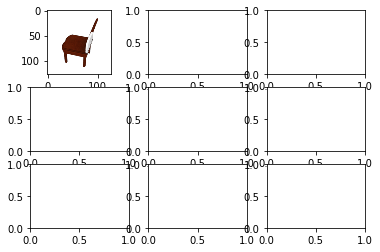

 Chamfer Cluster 3, Group 64.0: [2.11524136 2.57839557], Yaw: [0.7853981633974483, 1.5707963267948966], Pitch: [0.0, 0.7853981633974483]


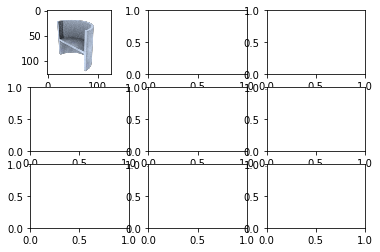

 Chamfer Cluster 3, Group 128.0: [5.45436937 4.74600616], Yaw: [1.5707963267948966, 2.356194490192345], Pitch: [0.0, 0.7853981633974483]


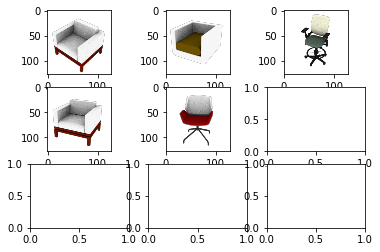

 Chamfer Cluster 3, Group 192.0: [2.79968429 5.51608642], Yaw: [2.356194490192345, 3.141592653589793], Pitch: [0.0, 0.7853981633974483]


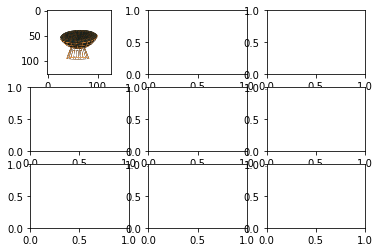

 Chamfer Cluster 3, Group 248.0: [2.59794518 2.902465  ], Yaw: [2.356194490192345, 3.141592653589793], Pitch: [5.497787143782138, 6.283185307179586]


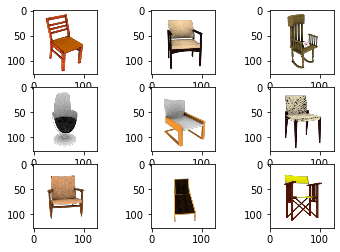

 Chamfer Cluster 3, Group 256.0: [4.04978064 3.67934357], Yaw: [3.141592653589793, 3.9269908169872414], Pitch: [0.0, 0.7853981633974483]


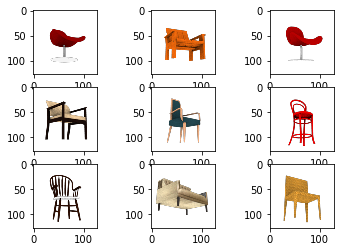

 Chamfer Cluster 3, Group 312.0: [2.84606896 2.86515859], Yaw: [3.141592653589793, 3.9269908169872414], Pitch: [5.497787143782138, 6.283185307179586]


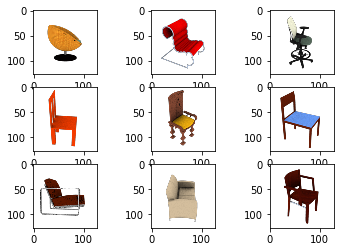

 Chamfer Cluster 3, Group 320.0: [3.01748247 2.77319077], Yaw: [3.9269908169872414, 4.71238898038469], Pitch: [0.0, 0.7853981633974483]


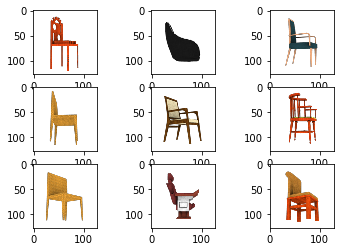

 Chamfer Cluster 3, Group 376.0: [2.68152348 2.83617145], Yaw: [3.9269908169872414, 4.71238898038469], Pitch: [5.497787143782138, 6.283185307179586]


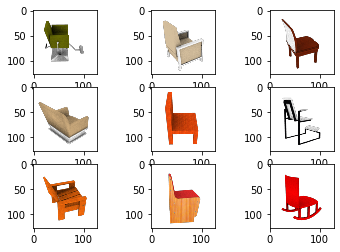

 Chamfer Cluster 3, Group 384.0: [4.33246446 4.03745312], Yaw: [4.71238898038469, 5.497787143782138], Pitch: [0.0, 0.7853981633974483]


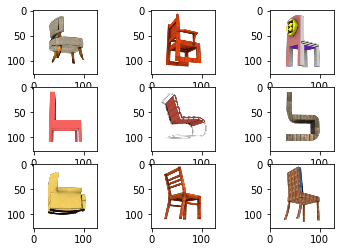

 Chamfer Cluster 3, Group 440.0: [2.79537595 3.2777824 ], Yaw: [4.71238898038469, 5.497787143782138], Pitch: [5.497787143782138, 6.283185307179586]


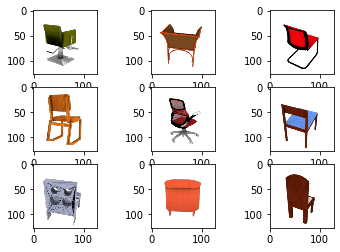

 Chamfer Cluster 3, Group 448.0: [4.74053715 3.98950271], Yaw: [5.497787143782138, 6.283185307179586], Pitch: [0.0, 0.7853981633974483]


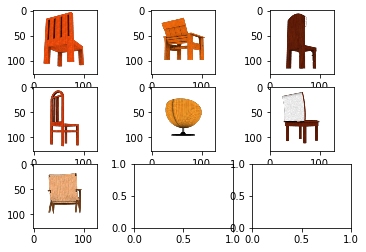

 Chamfer Cluster 3, Group 504.0: [2.48760073 2.19478357], Yaw: [5.497787143782138, 6.283185307179586], Pitch: [5.497787143782138, 6.283185307179586]
(625, 128, 128, 3)


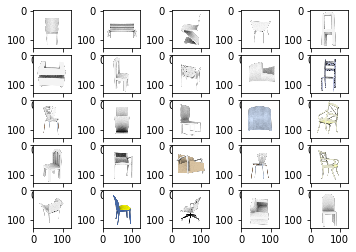

Chamfer Cluster 4: [3.2943737  3.16966247]


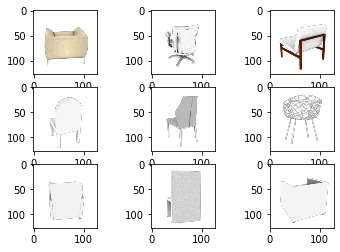

 Chamfer Cluster 4, Group 0.0: [4.15268792 3.88390479], Yaw: [0.0, 0.7853981633974483], Pitch: [0.0, 0.7853981633974483]


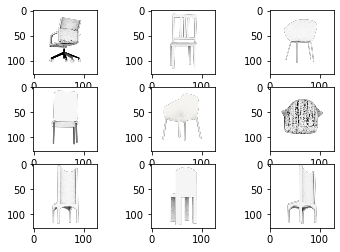

 Chamfer Cluster 4, Group 56.0: [3.49845642 2.9003859 ], Yaw: [0.0, 0.7853981633974483], Pitch: [5.497787143782138, 6.283185307179586]


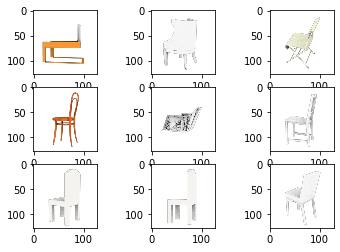

 Chamfer Cluster 4, Group 64.0: [3.46622503 3.21135013], Yaw: [0.7853981633974483, 1.5707963267948966], Pitch: [0.0, 0.7853981633974483]


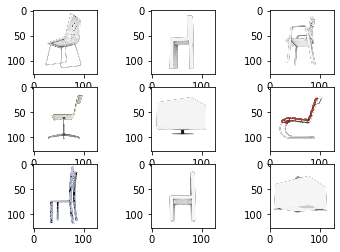

 Chamfer Cluster 4, Group 120.0: [2.50763319 2.68870226], Yaw: [0.7853981633974483, 1.5707963267948966], Pitch: [5.497787143782138, 6.283185307179586]


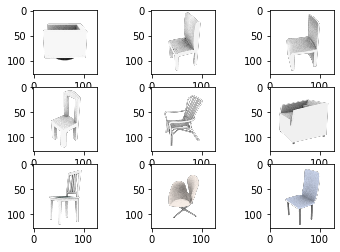

 Chamfer Cluster 4, Group 128.0: [2.97730631 3.16608876], Yaw: [1.5707963267948966, 2.356194490192345], Pitch: [0.0, 0.7853981633974483]


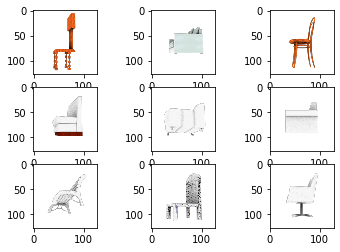

 Chamfer Cluster 4, Group 184.0: [3.74992415 4.01819027], Yaw: [1.5707963267948966, 2.356194490192345], Pitch: [5.497787143782138, 6.283185307179586]


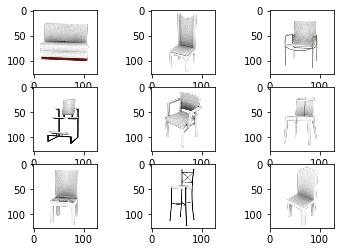

 Chamfer Cluster 4, Group 192.0: [3.18442897 2.80138694], Yaw: [2.356194490192345, 3.141592653589793], Pitch: [0.0, 0.7853981633974483]


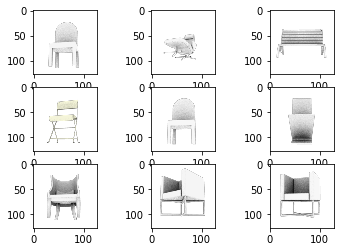

 Chamfer Cluster 4, Group 248.0: [5.12741851 4.04077551], Yaw: [2.356194490192345, 3.141592653589793], Pitch: [5.497787143782138, 6.283185307179586]


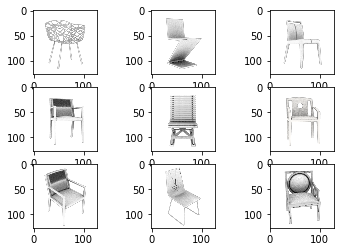

 Chamfer Cluster 4, Group 256.0: [3.65344356 3.37860887], Yaw: [3.141592653589793, 3.9269908169872414], Pitch: [0.0, 0.7853981633974483]


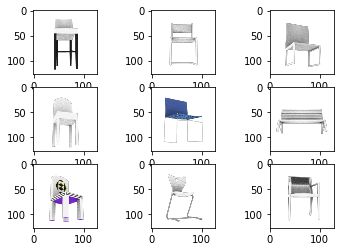

 Chamfer Cluster 4, Group 312.0: [3.50364447 3.49206858], Yaw: [3.141592653589793, 3.9269908169872414], Pitch: [5.497787143782138, 6.283185307179586]


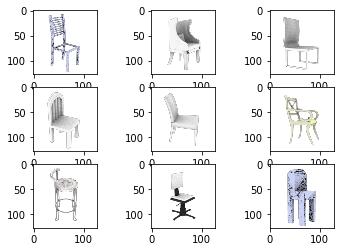

 Chamfer Cluster 4, Group 320.0: [3.07874335 2.70293676], Yaw: [3.9269908169872414, 4.71238898038469], Pitch: [0.0, 0.7853981633974483]


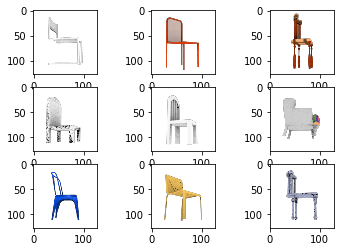

 Chamfer Cluster 4, Group 376.0: [3.00848958 2.94290532], Yaw: [3.9269908169872414, 4.71238898038469], Pitch: [5.497787143782138, 6.283185307179586]


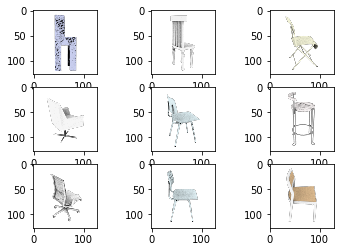

 Chamfer Cluster 4, Group 384.0: [2.73376387 2.79328038], Yaw: [4.71238898038469, 5.497787143782138], Pitch: [0.0, 0.7853981633974483]


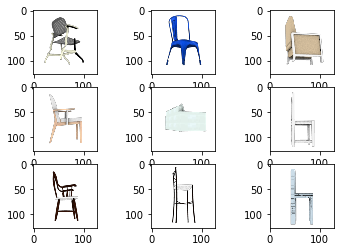

 Chamfer Cluster 4, Group 440.0: [3.06931608 3.4489599 ], Yaw: [4.71238898038469, 5.497787143782138], Pitch: [5.497787143782138, 6.283185307179586]


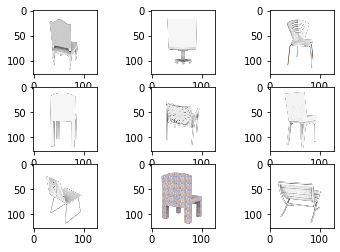

 Chamfer Cluster 4, Group 448.0: [3.35685732 3.18593267], Yaw: [5.497787143782138, 6.283185307179586], Pitch: [0.0, 0.7853981633974483]


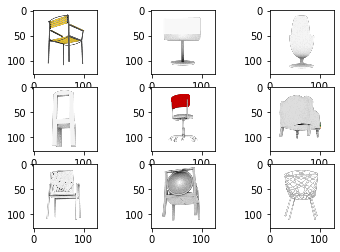

 Chamfer Cluster 4, Group 504.0: [2.88041245 2.6697916 ], Yaw: [5.497787143782138, 6.283185307179586], Pitch: [5.497787143782138, 6.283185307179586]


In [19]:
def chamfer_kmeans(kmeans, images_, chamfers_,groups_, n_cl,prepend='',n_displ=5):
    labels = kmeans.labels_
    for i in range(n_cl):
        mask = labels==i
        chamfers = chamfers_[mask]
        images = images_[mask]
        groups = groups_[mask]
        displ_str = prepend+'Chamfer Cluster {}: {}'.format(i,np.mean(chamfers,0)*100)
        print(images.shape)
        display_nn_images(images,n_displ, displ_str)
        uni_groups = np.unique(groups)
        for g in uni_groups:
            mask2 = groups==g
            images_g = images[mask2]
            chamfers_g = chamfers[mask2]
            yaw_r, pitch_r, roll_r = get_yaw_pitch_roll_range(g,divs)
            displ_str = prepend+' Chamfer Cluster {}, Group {}: {}, Yaw: {}, Pitch: {}'.format(i,g,np.mean(chamfers_g,0)*100,yaw_r, pitch_r)
            display_nn_images(images_g,n_displ-2, displ_str)


chamfer_kmeans(kmeans_all, all_images, chamfer_all,groups,n_clusters)
    